# Perceptron Learning Algorithm PLA

## Introduction

In [2]:
"""
Libraries needed to implement and visualize the PLA algorithm and its variant 
Adaline.
"""
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import imageio
import sys
import os
from IPython.display import HTML

# Images path
IMAGE_PATH = 'images/'

# setting up the figure size
rcParams["figure.figsize"] = 5, 5
rcParams.update({'figure.max_open_warning': 0})

In [3]:
class Perceptron:
    """
    PLA, Perceptron Learning Algorithm and Adaline, Adaptive Linear Neuron.

    Parameters
    ----------
        N : Integer
            Number of linearly separable points to generate.
        datarseed : Integer
            Seed used to initialize the datas random generator.
            Default: 1324
        rmispts : Boolean
            If True the misclassified points are selected randomly.
            Default: False
        misptsrseed : Integer
            Seed used to initialize the misclasifications random generator.
            Default: 1324
        dimension : Integer
            Dimension in which the points are generated.
            Default: 2
    Attributes
    ----------
        w : array
            Weights vector.
        X : array, shape = [nsamples, nfeatures]
            Training vectors, where 'nasamples' is the number of
            samples and 'nfeatures' is the number of features.
        V : array
            Line in 2d or n-plane in n-dimensions that separates the points.
        dim : array
            Dimension in which the algorithm works.
    """

    def __init__(
        self, N, datarseed=1324, rmispts=False, misptsrseed=1234, dimension=2
    ):

        self.dim = dimension
        self.rgendata = np.random.RandomState(datarseed)
        self.rgenmispts = np.random.RandomState(misptsrseed)
        self.rmispts = rmispts

        # Random linearly separated data,
        var = [self.rgendata.uniform(-1, 1) for i in range(self.dim * 2)]
        for i in range(self.dim + 1):
            if i == 0:
                self.V = np.array(
                    var[i + 2] * var[i + 1] - var[i] * var[i + 3])
            elif i % 2 == 0:
                self.V = np.append(self.V, var[i] - var[i - 1])
            else:
                self.V = np.append(self.V, var[i])

        self.X = self.generate_points(N)

    def generate_points(self, N):
        """
        Generate linearly separable data points method.

        Parameters
        -----------
        N : Integer
            Number of data points to generate.

        Returns
        --------
        X : array, shape = [nsamples, nfeatures]
            Training vectors, where 'nasamples' is the number of
            samples and 'nfeatures' is the number of features.

        """
        X = []
        for i in range(N):
            xn = [self.rgendata.uniform(-1, 1) for i in range(self.dim)]
            x = np.append([1], xn)
            s = int(np.sign(self.V.T.dot(x)))
            X.append((x, s))
        return X

    def plot(self, mispts=None, vec=None, save=False, imgname='tmp'):
        """
        2D data plot method.

        Parameters
        -----------
        mispts : array
            Set of misclassified data points.
            Default: None
        vec : array
            Weights vector that describes the hypotesis.
            Default: None
        save : Boolean
            If the value is True the plots are saved to disk.
            Default: False
        imgname : String
            Name used to save the plot to disk.
            Default: 'tmp'

        """

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        V = self.V

        a, b = -V[1] / V[2], -V[0] / V[2]
        l = np.linspace(-1, 1)

        plt.plot(l, a * l + b, 'k-')
        cols = {1: 'r', -1: 'b'}

        if mispts == None:
            for x, s in self.X:
                plt.plot(x[1], x[2], cols[s] + 'o')

        if mispts:
            for x, s in mispts:
                plt.plot(x[1], x[2], cols[s] + '.')

        if vec != None:
            aa, bb = -vec[1] / vec[2], -vec[0] / vec[2]
            plt.plot(l, aa * l + bb, 'g-', lw=2)

        if save:
            if not mispts:
                plt.title('N = %s' % (str(len(self.X))))
            else:
                plt.title(
                    'N = %s with %s test points' %
                    (str(len(self.X)), str(len(mispts)))
                )
            plt.savefig(
                IMAGE_PATH + imgname, dpi=200, bbox_inches='tight'
            )
            plt.close()

    def classification_error(self, vec, pts=None):
        """
        Error classification method.

        Parameters
        -----------
        vec : array
            Weights vector used to classify a point.
        pts : array
            Data points to evaluate:
            Default: self.X

        Returns
        --------
        error : float
            Fraction of misclassified points.
        mispts: array
            Set of misclassified points.

        """
        # Error defined as fraction of misclassified points
        if not pts:
            pts = self.X
        M = len(pts)
        n_mispts = 0
        mispts = []
        for x, s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                n_mispts += 1
                mispts.append((x, s))
        error = n_mispts / float(M)
        return error, mispts

    def choose_miscl_point(self, vec):
        """
        Choose a misclassified point method.

        Parameters
        -----------
        vec : array
            Weights vector used to classify a point.

        Returns
        --------
        mispts[i] : array
            Selected misclassified data point.

        """
        # Choose a random point among the misclassified
        pts = self.X
        mispts = []
        for x, s in pts:
            if int(np.sign(vec.T.dot(x))) != s:
                if not self.rmispts:
                    return (x, s)
                mispts.append((x, s))
        return mispts[self.rgenmispts.randint(0, len(mispts))]

    def pla(self, save=False, suffix=''):
        """
        Perceptron learning algorithm method.

        Parameters
        -----------
        save : Boolean
            If value is True Save the sequence of plots in which the algorithm 
            go through.
        suffix : String
            suffix to add to the name used to save the sequence of plots to disk.

        Returns
        --------
        it : Integer
            Number of iterations the algorithm took to converge.

        """

        # Initialize the weights to zeros
        w = np.zeros(self.dim + 1)
        X, N = self.X, len(self.X)

        it = 0
        # Iterate until all points are correctly classified
        while self.classification_error(w)[0] != 0:
            it += 1
            # Pick random misclassified point
            x, s = self.choose_miscl_point(w)
            # Update weights
            w += s * x
            if save:
                self.plot(vec=w.tolist())
                plt.title('N = %s, Iteration %s\n' % (str(N), str(it)))
                plt.savefig(
                    IMAGE_PATH + suffix + 'p_N%s_it%s' % (str(N), str(it)),
                    dpi=200, bbox_inches='tight'
                )
                plt.close()
        self.w = w
        return it

    def adaline(self, save=False, suffix='', lrate=1, limit=10):
        """
        Adaptive linear neuron algorithm method.

        Parameters
        -----------
        save : Boolean
            If value is True Save the sequence of plots in which the algorithm 
            go through.
        suffix : String
            suffix to add to the name used to save the sequence of plots to disk.
        lrate : float
            Learning rate factor.
        limit : Integer
            Maximum number of updates the algorithm does.

        Returns
        --------
        self : object

        """
        # Initialize the weigths to zeros
        w = np.zeros(self.dim + 1)
        X, N = self.X, len(self.X)

        it = 0
        # Iterate until all points are correctly classified
        while it < limit and self.classification_error(w)[0] != 0:
            it += 1
            # Pick random misclassified point
            x, s = self.choose_miscl_point(w)
            y = w.T.dot(x)
            # Update weights
            w += lrate * (s - y) * x
            if save:
                self.plot(vec=w.tolist())
                plt.title('N = %s, Iteration %s\n' % (str(N), str(it)))
                plt.savefig(
                    IMAGE_PATH + suffix + 'p_N%s_it%s' % (str(N), str(it)),
                    dpi=200, bbox_inches='tight'
                )
                plt.close()
        self.w = w
        return it

    def check_error(self, M, vec):
        """
        Test data error check method.

        Parameters
        -----------
        N : Integer
            Number of data points to generate.
        vec : array
            Weights vector, generated by running the algorithm with a training
            set, used to classify the data points.

        Returns
        --------
        error : float
            Fraction of misclassified points.
        miscpoints: array
            Set of misclassified points.
        check_pts: array
            The generated data points.

        """
        check_pts = self.generate_points(M)
        error, miscpoints = self.classification_error(vec, pts=check_pts)
        return error, miscpoints, check_pts

## Visualize

In [4]:
def get_images(suffix):
    """
    Get the list of images associated to a suffix.

    Parameters
    -----------
    suffix : String
        Suffix of set of requested images.

    Returns
    --------
    sortpngs : array
        Set of images (plots) names.

    """
    basedir = os.getcwd()
    os.chdir(basedir)
    pngs = [pl for pl in os.listdir(IMAGE_PATH) if pl.endswith(
        'png') and pl.startswith(suffix)]
    sortpngs = sorted(pngs, key=lambda a: int(a.split('it')[1][:-4]))
    return sortpngs

In [5]:
def show_animation(image1, image2):
    """
    Show images or animations method.

    Parameters
    -----------
    image1 : String
        image url.
    image2 : String
        image url.

    Returns
    --------
    htmlcode : HTML

    """
    header = "<html><head><style>*{box-sizing:border-box;}.column{float:left;width:50%;padding:2px;}/*Clearfix(clearfloats)*/.row::after{content:"";clear:both;display:table;}</style></head><body>"
    footer = "</body></html>"
    return HTML(
        header +
        '''
        <div class="row">
            <div class="column">
            <img style="display: block;margin-left: auto;margin-right: auto;width: 60%;" src="''' + IMAGE_PATH + image1 + '''">
            </div>
            <div class="column">
            <img style="display: block;margin-left: auto;margin-right: auto;width: 60%;" src="''' + IMAGE_PATH + image2 + '''">
            </div>
        </div>
        '''
        + footer
    )

In [6]:
def create_animation(filenames, duration=0.50, name='tmp'):
    """
    Create gif animation method. 

    Parameters
    -----------
    filenames : array
        Set of the images names to create the animation.
    duration : float
        Duration of one image in the animation.
    name : String
        Name used to save the animation to disk.

    Returns
    --------
    gifname : String
        Name of the animation file.

    """
    images = []
    for filename in filenames:
        images.append(imageio.imread(IMAGE_PATH + filename))
    gifname = name + ".gif"
    output_file = IMAGE_PATH + '%s' % gifname
    imageio.mimsave(output_file, images, duration=duration)
    return gifname

## PLA, Problem 1.4  

<p>
    Generate a linearly separable data set of size 20. Plot the examples {(xn , Yn)}
as well as the target function f on a plane. Be sure to mark the examples from
different classes differently, and add labels to the axes of the plot.
</p>  

In [7]:
p_b = Perceptron(20,datarseed=1995)

<p>
    Run the perceptron learning algorithm on the data set above. Report the
number of updates that the algorithm takes before converging. Plot the
examples { (xn, Yn) } , the target function f, and the final hypothesis g in
the same figure. Comment on whether f is close to g.
</p>

In [8]:
iterations = p_b.pla(save=True, suffix='pb_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 11


In [9]:
images = get_images('pb_')
animation = create_animation(images,0.50,name='animation_pb_1995')
show_animation(animation, images[-1])

<p>
Repeat everything in (b) with another randomly generated data set of
size 20. Compare you r results with (b).
</p>

In [10]:
p_c = Perceptron(20,datarseed=1996)

In [11]:
iterations = p_c.pla(save=True, suffix='pc_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 22


In [12]:
images = get_images('pc_')
animation = create_animation(images,0.50,name='animation_pc_1996')
show_animation(animation, images[-1])

<p>
 Repeat everything in (b) with a nother randomly generated data set of
size 100. Compare you r results with (b).
</p>

In [13]:
p_d = Perceptron(100,datarseed=7878)

In [14]:
iterations = p_d.pla(save=True, suffix='pd_')
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 75


In [15]:
images = get_images('pd_')
animation = create_animation(images,0.50,name='animation_pd_7878')
show_animation(animation, images[-1])

<p>
Repeat everything in (b) with a nother randomly generated data set of
size 1, 000. Compare you r results with (b)
</p>

In [16]:
p_e = Perceptron(1000,datarseed=2000)
p_e.plot(save=True, imgname='pe_sample_2000')

In [17]:
iterations = p_e.pla()
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 432


In [18]:
p_e.plot(vec=p_e.w.tolist(), save=True, imgname='animation_pe_sample_2000')
show_animation('pe_sample_2000.png', 'animation_pe_sample_2000.png')

<p>
Modify the algorithm such that it takes Xn E J10 instead of J2 . Randomly generate a linearly separable data set of size 1, 000 with Xn E J10 and feed the data set to the a lgorithm. How many updates does the
a lgorithm take to converge?
</p>

In [19]:
p_f = Perceptron(1000,datarseed=2003,dimension=10)
iterations = p_f.pla()
print("Number of iteratios: %d" % (iterations))

Number of iteratios: 4569


Repeat the a lgorithm on the same data set as (f) fr 100 experiments. In
the iterations of each experiment, pick x(t) randomly instead of deterministically. Plot a histogram fr the number of updates that the algorithm
takes to converge.

In [20]:
p_g = Perceptron(1000,datarseed=2003, rmispts=True, misptsrseed=8745, dimension=10)
aiter = []
for i in range(100):
    iterations = p_g.pla()
    aiter.append(iterations)
    #print("Number of iteratios: %d" % (iterations))

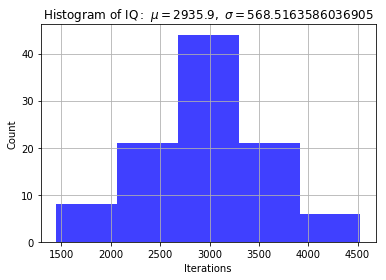

In [21]:
x = np.array([1825, 2463, 2989, 3115, 2389, 2175, 2101, 3383, 2983, 2777,
              3313, 2802, 3275, 3553, 1964, 3111, 2999, 3741, 3421, 3088,
              2941, 3097, 2377, 3447, 2615, 2783, 2905, 2675, 2215, 3241,
              3373, 2989, 2863, 3637, 3229, 2685, 3625, 2127, 2537, 3995,
              2743, 2821, 3339, 2684, 3571, 2569, 2129, 3011, 2115, 3951,
              2839, 2035, 2677, 4323, 3303, 2947, 2919, 1978, 3337, 2541,
              3203, 3043, 2857, 2917, 2541, 3333, 2615, 4045, 3305, 2791,
              2499, 3313, 3627, 2701, 3099, 2857, 3043, 2885, 2651, 2729,
              2987, 3535, 1445, 2789, 2195, 2819, 2896, 3587, 2301, 2943,
              3979, 2059, 2003, 3113, 3689, 3041, 2019, 3825, 3127, 4529]
            )

plt.gcf().clear()

# the histogram of the data
n, bins, patches = plt.hist(x, 5, facecolor='blue', alpha=0.75)
plt.xlabel('Iterations')
plt.ylabel('Count')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=' + str(x.mean()) + ',\ \sigma='+ str(x.std()) +'$')
plt.grid(True)

plt.show()

<p>
Summarize your conclusions with respect to accuracy a nd running time
as a function of N and d.
</p>

## ADALINE, Problem 1.5

<p>
(a) Generate a tra ining data set of size 100 similar to that used in Exercise 1 .4.
Generate a test data set of size 10, 000 from the same process. To get g,
run the a lgorithm a bove with ' = 100 on the training data set, u ntil
a maximum of 1 , 000 updates has been reached. Plot the training data
set, the target function f, and the final hypothesis g on the same figure.
Report the error on the test set
</p>

In [22]:
pada_a = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)

iterations = pada_a.adaline(lrate=4, limit=1000)
print("Number of iteratios: %f" % (iterations))

Number of iteratios: 1000.000000


In [23]:
error, miscpoints, x = pada_a.check_error(10000,pada_a.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_a.plot(vec=pada_a.w.tolist(), save=True, imgname='pada_4_10000')
plt.gcf().clear()
pada_a.plot(mispts=miscpoints, save=True, imgname='pada_4_miscpoints')
show_animation('pada_4_10000.png','pada_4_miscpoints.png')

fraction of misclassified points: 0.302700


<p>
(b) Use the data set in (a) and redo everything with ' = 1
</p>

In [24]:
pada_b = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)

iterations = pada_b.adaline(lrate=1, limit=1000)
print("Number of iteratios: %f" % (iterations))

Number of iteratios: 48.000000


In [25]:
error, miscpoints, x = pada_b.check_error(10000,pada_b.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_b.plot(vec=pada_b.w.tolist(), save=True, imgname='pada_1_10000')
plt.gcf().clear()
pada_b.plot(mispts=miscpoints, save=True, imgname='pada_1_miscpoints')
show_animation('pada_1_10000.png','pada_1_miscpoints.png')

fraction of misclassified points: 0.007400


<p>
(c) Use the data set in (a) and redo everything with ' = 0.01
</p>

In [26]:
pada_c = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)
iterations = pada_c.adaline(lrate=0.01, limit=1000)

print("Number of iteratios: %f" % (iterations))

Number of iteratios: 603.000000


In [27]:
error, miscpoints, x = pada_c.check_error(10000,pada_c.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_c.plot(vec=pada_c.w.tolist(), save=True, imgname='pada_001_10000')
plt.gcf().clear()
pada_c.plot(mispts=miscpoints, save=True, imgname='pada_001_miscpoints')
show_animation('pada_001_10000.png','pada_001_miscpoints.png')

fraction of misclassified points: 0.003800


<p>
(d) Use the data set in (a) and redo everything with ' = 0.0001
</p>

In [28]:
pada_d = Perceptron(100, datarseed=1995, rmispts=True, misptsrseed=8955)
iterations = pada_d.adaline(lrate=0.0001, limit=1000)

print("Number of iteratios: %f" % (iterations))

Number of iteratios: 205.000000


In [29]:
error, miscpoints, x = pada_d.check_error(10000,pada_d.w)
print("fraction of misclassified points: %f" % error)
plt.gcf().clear()
pada_d.plot(vec=pada_d.w.tolist(), save=True, imgname='pada_00001_10000')
plt.gcf().clear()
pada_d.plot(mispts=miscpoints, save=True, imgname='pada_00001_miscpoints')
show_animation('pada_00001_10000.png','pada_00001_miscpoints.png')

fraction of misclassified points: 0.007500
